In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns
from matplotlib import pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

from sintetic_data import gerar_dados_sinteticos
from utils import classificar, final_pre_process, MeanEmbeddingVectorizer
%matplotlib inline


[nltk_data] Downloading package punkt to /home/raphael/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/raphael/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/raphael/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/raphael/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/raphael/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/raphael/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/raphael/nltk_data...
[n

In [24]:
# Gera dados sintéticos
data = gerar_dados_sinteticos(20000, noise=True, error = 0.5)

In [3]:
# Classifica a coluna tipo entre melhoria(1) e corretiva(0)
data["Tipo"] = data["Tipo"].apply(classificar)

In [4]:
# Alterar tipo para categoria
data['Tipo'] = data['Tipo'].astype('category')

In [5]:
# Divide os dados em conjuntos de treinamento e teste
df_train, df_test = train_test_split(data, test_size=0.2, random_state=42)

Tipo
melhoria     10033
corretiva     9967
Name: count, dtype: int64


<Axes: xlabel='Tipo', ylabel='count'>

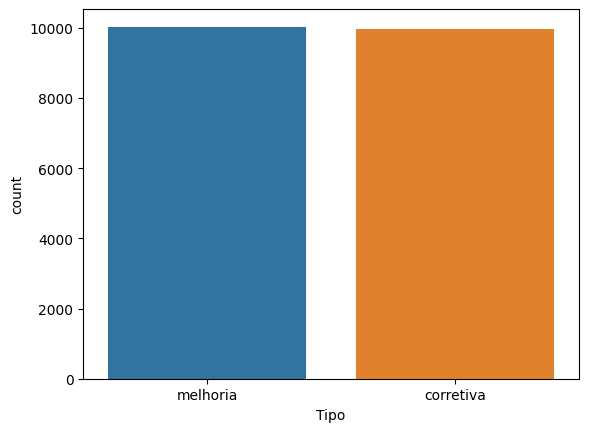

In [25]:
x = data['Tipo'].value_counts()
print(x)
sns.barplot(x=x.index, y=x, hue=x.index)

In [7]:
# pre-processing

df_train['clean_text'] = df_train['Descrição'].apply(lambda x: final_pre_process(x))
df_train.head()


,Descrição,Tipo,clean_text
5894,Instalar computadores na sala de reuniões,1,instalar computadores sala reuniões
3728,Campainha está com defeito para novos funcioná...,0,campainha defeito novos funcionários
8958,Roteador reiniciando aleatoriamente devido a a...,0,roteador reiniciando aleatoriamente devido atu...
7671,VPN for@ de funcionamento com prioridade alta,0,vpn funcionamento prioridade alta
5999,Computador não está ligado após queda de energia,0,computador ligado após queda energia


In [8]:
# Vectorization
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(df_train["clean_text"],df_train["Tipo"],test_size=0.2,shuffle=True)

In [9]:
#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [10]:
# Word2Vec
# Word2Vec runs on tokenized sentences
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

In [11]:
#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [12]:
#Word2Vec
df_train['clean_text_tok']=[nltk.word_tokenize(i) for i in df_train['clean_text']]
model = Word2Vec(df_train['clean_text_tok'],min_count=1)     
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))
modelw = MeanEmbeddingVectorizer(w2v)

In [13]:
# converting text to numerical data using Word2Vec
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_test_vectors_w2v = modelw.transform(X_test_tok)

In [14]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1596
           1       1.00      1.00      1.00      1604

    accuracy                           1.00      3200
   macro avg       1.00      1.00      1.00      3200
weighted avg       1.00      1.00      1.00      3200

Confusion Matrix: [[1596    0]
 [   0 1604]]
AUC: 0.9999999999999999


In [15]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression (W2v)
lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model
#Predict y value for test dataset
y_predict = lr_w2v.predict(X_test_vectors_w2v)
y_prob = lr_w2v.predict_proba(X_test_vectors_w2v)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1596
           1       1.00      0.98      0.99      1604

    accuracy                           0.99      3200
   macro avg       0.99      0.99      0.99      3200
weighted avg       0.99      0.99      0.99      3200

Confusion Matrix: [[1593    3]
 [  29 1575]]
AUC: 0.999833202082513


In [16]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1596
           1       0.98      1.00      0.99      1604

    accuracy                           0.99      3200
   macro avg       0.99      0.99      0.99      3200
weighted avg       0.99      0.99      0.99      3200

Confusion Matrix: [[1566   30]
 [   1 1603]]
AUC: 0.999957421608885


In [22]:
lr_tfidf.predict_proba(tfidf_vectorizer.transform(['campainha com defeito']))

array([[9.99439774e-01, 5.60225915e-04]])

In [18]:
# 0 = corretiva, 1 = melhoria
lr_tfidf.classes_

array([0, 1])